First we create submodels for the causal Markov kernels.

In [1]:
# !pip3 install torch torchvision torchaudio
# !pip install pyro-ppl

In [2]:
import torch
import torch.distributions.constraints as constraints
import numpy as np
import pandas as pd

import pyro
from pyro.distributions import Bernoulli, Categorical, Normal
from pyro.distributions import Dirichlet, Beta, InverseGamma
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib 
import scipy

In [3]:
print(f"pytorch version {torch.__version__}")
print(f"numpy version {np.__version__}")
print(f"pandas version {pd.__version__}")
print(f"pyro version {pyro.__version__}")
print(f"matplotlib version {matplotlib.__version__}")
print(f"scipy version {scipy.__version__}")


pytorch version 1.9.0+cu102
numpy version 1.19.5
pandas version 1.1.5
pyro version 1.7.0
matplotlib version 3.2.2
scipy version 1.4.1


In [4]:
# Set up plotting info
color_red = '#fc4f30'
color_yellow = '#e5ae38'
color_green = '#6d904f'
color_blue = '#30a2da'
color_gray = '#8b8b8b'
color_purple = '#8c2587'
plt.style.use('fivethirtyeight')

Build the submodels for the Roman variables.

In [5]:
def house_model(house_probs):
    """Probabilistic model representing generating house data.

    Args: None.

    Returns:
        house_idx: pytorch tensor where the value represents the index corresponding 
            to a Hogwarts houses.
            shape: (N), where N: number of data points.
    """
    house_idx = pyro.sample("house", Categorical(probs=house_probs))
    return house_idx

def personality_model(house_idx, personality_probs):
    """Probabilistic model representing generating personality data given 
    house and personality probabilities.

    Args:
        house_idx: pytorch tensor where the value represents the index corresponding 
            to a Hogwarts houses.
            shape: (N), where N: number of data points.

        personality_probs: pytorch tensor of personality type probabilities 
            for each house.
            shape: (N, num_houses, num_personalities), where N: number of data points.

    Returns:
        personality_idx: pytorch tensor where the value represents the index 
            corresponding to the four personality types A, B, C or D.
            shape: (N, num_houses, num_personality_types) 
            where N: number of data points.
    """
    probs = personality_probs[house_idx]
    personality_idx = pyro.sample("personality", Categorical(probs=probs))
    return personality_idx

def herbology_model(house_idx, herbology_probs):
    """Probabilistic model representing generating herbology score data given 
    house and herbology score probabilities.

    Args:
        house_idx: pytorch tensor where the value represents the index corresponding 
            to a Hogwarts houses.
            shape: (N), where N: number of data points.

        herbology_probs: pytorch tensor of herbology score probabilities for each house.
            shape: (N, num_houses), where N: number of data points.

    Returns:
        herbology: pytorch tensor where the value represents the index corresponding 
            to either a strong or weak herbology score.
            shape: (N), where N: number of data points.
    """
    prob = herbology_probs[0][house_idx]
    herbology = pyro.sample("herbology", Bernoulli(probs=prob))
    return herbology

def quidditch_rank_model(house_idx, params):
    """Probabilistic model representing generating quidditch ranking scores data given 
    house and Normal distribution sampling parameters.

    Args:
        house_idx: pytorch tensor where the value represents the index corresponding 
            to a Hogwarts houses.
            shape: (N), where N: number of data points.

        params: a tuple of pytorch tensors representing loc and scale parameters.
            shape: (N, num_houses), where N: number of data points.

    Returns:
        score: pytorch tensor where the value represents a student's quidditch score.
            shape: (N), where N: number of data points.
    """
    mus, scales = params
    mu = mus[house_idx]
    scale = scales[house_idx]
    score = pyro.sample("quidditch_rank", Normal(mu, scale))
    return score

Build the priors for the parameters of each causal Markov kernel (the Greek variables).  I'll use these priors as proposals in the guide function.

In [6]:
def house_param_prior():
    """The prior probability distribution before any house data is observered.

    Assumption:
        1. The houses are equally probable so we use an informative prior.
        2. House concentrations should be between 10 and 20 since some houses may be 
           "stickier" than others.
           Using constraint=constraints.positive or constraint=constraints.simplex 
           collapses the concentrations where one house dominates for example [0 1 0 0].

    Args: None.

    Returns:
        probs: pytorch tensor where the value represents the probability of selecting
            a Hogwarts house.
            shape: (N, num_houses), where N: number of data points.
    """
    concentrations = pyro.param(
        "house_concentration", torch.ones(4), constraint=constraints.interval(10, 20))
    probs = pyro.sample("house_probs", Dirichlet(concentrations))
    return probs


def personality_param_prior():
    """The prior probability distribution before any personality type data
    is observered.

    Assumption:
        The personality types are equally probable so we use an informative prior.

    Args: None.

    Returns:
        probs: pytorch tensor where the value represents the probability of selecting
            a personality type.
            shape: (N, num_houses, num_personalities), where N: number of data points.
    """
    concentration = pyro.param(
        "personality_concentration", torch.ones(4, 4), constraint=constraints.positive)
    probs = pyro.sample("personality_probs", Dirichlet(concentration).independent(1))
    return probs


def herbology_param_prior():
    """The prior probability distribution before any herbology strength data
    is observered.

    Assumption:
        1. The probability of a student receiving a strong or weak herbology score are
           equally probable so we use an informative prior.
        2. The expected probability for the Beta distribution is 0.50.

    Args: None.

    Returns:
        probs: pytorch tensor where the value represents the probability of selecting
            a strong herbology score.
            shape: (N), where N: number of data points.
    """
    alpha = pyro.param(
        "herbology_alpha", torch.ones(1, 4), constraint=constraints.positive)
    beta = pyro.param(
        "herbology_beta", torch.ones(1, 4), constraint=constraints.positive)
    prob = pyro.sample(
        "herbology_prob", Beta(alpha, beta).independent(1))

    return prob


def quidditch_parameter_prior():
    """The prior probability distribution before any quidditch ranking data
    is observered.

    Assumption:
        1. Quidditch skill and thus ranking is normally distributed so we use
           an informative prior.
        2. The mean ranking is 500 with a standard deviation of ~22.
        3. The standard deviation for the mean ranking should be larger than 1.0.

    Args: None.

    Returns:
        means: pytorch tensor where the value represents the average quidditch ranking.
            shape: (N), where N: number of data points.
        scales: pytorch tensor representing the standard deviation of the
            quidditch ranking.
            shape: (N), where N: number of data points.
    """
    mean_loc = pyro.param(
        "quidditch_mean_loc",
        torch.tensor(4 * [500.], dtype=torch.float64))

    # standard deviation will be larger than 1.0 but less than 500
    mean_scale = pyro.param(
        "quidditch_mean_scale",
        torch.tensor(4 * [500.**.5], dtype=torch.float64),
        constraint=constraints.interval(1, 500))

    scale_a = pyro.param(
        "quidditch_scale_a",
        torch.tensor(4 * [1.35], dtype=torch.float64),
        constraint=constraints.greater_than(0.0))
    
    scale_b = pyro.param(
        "quidditch_scale_b",
        torch.tensor(4 * [10.0], dtype=torch.float64),
        constraint=constraints.greater_than(0.0))

    means = pyro.sample(
        "quidditch_rank_means",
        Normal(mean_loc, mean_scale).independent(1))

    scales = pyro.sample(
        "quidditch_rank_scales",
        InverseGamma(scale_a, scale_b).independent(1))

    return means, scales

Now we specify the model.

In [7]:
def model(N):
    """Probabilistic model representing the entire Hogwarts data generation process.

    Args:
        N: integer size of the data set.

    Returns:
        All returned items have the same tensor shape.
        Shape: (N).

        personality: pytorch tensor where the value represents the index
            corresponding to the four personality types A, B, C or D.

        herbology: pytorch tensor where the value represents the index corresponding
            to either a strong or weak herbology score.

        score: pytorch tensor where the value represents the quidditch score.
    """
    # sample once from prior distribution at the beginning of a run
    house_probs = house_param_prior()
    personality_probs = personality_param_prior()
    herbology_probs = herbology_param_prior()
    quidditch_params = quidditch_parameter_prior()

    # model feature data as vector of conditionally independent variables that depend
    # depend on the prior probabilities
    with pyro.plate("iid", N):
        house = house_model(house_probs)
        personality = personality_model(house, personality_probs)
        herbology = herbology_model(house, herbology_probs)
        quidditch_rank = quidditch_rank_model(house, quidditch_params)
    return personality, herbology, quidditch_rank


print(model(10))

(tensor([1, 1, 3, 0, 1, 0, 0, 2, 0, 2]), tensor([1., 0., 1., 0., 1., 0., 0., 1., 1., 0.]), tensor([509.9885, 490.7374, 535.2104, 550.4053, 502.0199, 557.5776, 536.0430,
        493.6045, 542.0382, 496.2162], dtype=torch.float64,
       grad_fn=<AddBackward0>))


In our guide function, we'll simply use the model under the prior distribution to generate candidate samples.  So we'll just use the original model, minus the variables we will observe in the data (personality, herbology, quidditch rank).

In [8]:
def guide(N):
    """Stochastic function approximating the posterior distribution required for
    inference.

    Args:
        N: integer size of data set.

    Returns:
        house: pytorch tensor where the value represents the index corresponding
            to a Hogwarts house.
            shape: (N), where N: number of data points.
    """
    house_probs = house_param_prior()
    personality_probs = personality_param_prior()
    herbology_probs = herbology_param_prior()
    quidditch_params = quidditch_parameter_prior()

    with pyro.plate("iid", N):
        house = house_model(house_probs)

    return house


guide(10)

tensor([2, 0, 0, 0, 2, 2, 2, 3, 2, 0])

In [9]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


Load the data.

In [10]:
unsupervised_filepath = (
    "/drive/My Drive/CS7290_Hogwarts_Project/hogwarts_unsupervised_ground_truth.csv")
dataframe = pd.read_csv(unsupervised_filepath)
N = dataframe.shape[0]
data_dict = {k: torch.tensor(v, dtype=torch.float64) for k, v in dataframe.items()}

Sample from the prior distribution.

In [11]:
# draw 1000 samples from the prior
prior_samples = Predictive(model, {}, num_samples=1000)(1)

# Check Predictive to see what we can view
for k, v in prior_samples.items():
    print(f"{k}: {tuple(v.shape)}")

prior_house_probs = prior_samples["house_probs"]
prior_personality_probs = prior_samples["personality_probs"]
prior_herbology_prob = prior_samples["herbology_prob"]
prior_quidditch_rank_means = prior_samples["quidditch_rank_means"]
prior_quidditch_rank_scales = prior_samples["quidditch_rank_scales"]

mean_prior_house_probs = torch.mean(prior_house_probs, 0)
mean_prior_personality_probs = torch.mean(prior_personality_probs, 0)
mean_prior_herbology_prob = torch.mean(prior_herbology_prob, 0)
mean_prior_quidditch_rank_means = torch.mean(prior_quidditch_rank_means, 0)
mean_prior_quidditch_rank_scales = torch.mean(prior_quidditch_rank_scales, 0)

print(mean_prior_house_probs)
print("\n")
print(mean_prior_personality_probs)
print("\n")
print(mean_prior_herbology_prob)
print("\n")
print(mean_prior_quidditch_rank_means)
print("\n")
print(mean_prior_quidditch_rank_scales)

house_probs: (1000, 1, 4)
personality_probs: (1000, 1, 4, 4)
herbology_prob: (1000, 1, 4)
quidditch_rank_means: (1000, 1, 4)
quidditch_rank_scales: (1000, 1, 4)
house: (1000, 1)
personality: (1000, 1)
herbology: (1000, 1)
quidditch_rank: (1000, 1)
tensor([[0.2498, 0.2481, 0.2530, 0.2491]])


tensor([[[0.2577, 0.2496, 0.2484, 0.2442],
         [0.2617, 0.2434, 0.2500, 0.2449],
         [0.2465, 0.2540, 0.2506, 0.2488],
         [0.2436, 0.2438, 0.2576, 0.2549]]])


tensor([[0.5017, 0.4959, 0.5003, 0.4879]])


tensor([[499.6605, 499.1143, 499.9514, 499.5534]], dtype=torch.float64)


tensor([[27.4882, 20.4790, 34.3460, 24.5218]], dtype=torch.float64)


In [12]:
# Clear out params
pyro.clear_param_store()

# Condition model on data
conditioned_model = pyro.condition(model, data_dict)

# Set Optimization Hyperparameters
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
criterion = Trace_ELBO()
svi = SVI(
    model=conditioned_model,
    guide=guide,
    optim=optimizer,
    loss=Trace_ELBO()
)

num_steps = 1001
epochs = 3
for epoch in range(epochs):
    print(f"Current epoch {epoch+1}.")
    for i in range(num_steps):
        current_loss = svi.step(N)
        if (i % 100 == 0):
            print(f"iter: {i}, loss: {round(current_loss, 2)}")
    print(f"End of epoch {epoch+1}.\n")
    print("\n")

print("\n")
print("End of Learning.")
print("\n")


Current epoch 1.
iter: 0, loss: 36699.11
iter: 100, loss: 1388.01
iter: 200, loss: 1666.04
iter: 300, loss: 987.74
iter: 400, loss: 1989.38
iter: 500, loss: 976.77
iter: 600, loss: 965.33
iter: 700, loss: 1688.47
iter: 800, loss: 4752.88
iter: 900, loss: 1024.63
iter: 1000, loss: 864.92
End of epoch 1.



Current epoch 2.
iter: 0, loss: 1021.87
iter: 100, loss: 1006.03
iter: 200, loss: 1179.96
iter: 300, loss: 1035.96
iter: 400, loss: 1143.76
iter: 500, loss: 977.83
iter: 600, loss: 1117.42
iter: 700, loss: 1397.31
iter: 800, loss: 1013.16
iter: 900, loss: 1232.73
iter: 1000, loss: 864.9
End of epoch 2.



Current epoch 3.
iter: 0, loss: 911.95
iter: 100, loss: 1051.05
iter: 200, loss: 1040.95
iter: 300, loss: 1303.44
iter: 400, loss: 1423.69
iter: 500, loss: 871.15
iter: 600, loss: 1506.61
iter: 700, loss: 927.45
iter: 800, loss: 946.8
iter: 900, loss: 953.75
iter: 1000, loss: 1026.29
End of epoch 3.





End of Learning.




Extract learned probability parameters.

In [13]:
print("The following parameters are logged:")
all_params = pyro.get_param_store()
for k, v in all_params.items():
  prob_parameters = np.round(v.detach().numpy(), 2)
  print(f"{k}\n{prob_parameters}\n")

house_concentrations = pyro.param("house_concentration")
personality_concentrations = pyro.param("house_concentration")
herbology_alphas = pyro.param("herbology_alpha")
herbology_betas = pyro.param("herbology_beta")
quidditch_mean_locs = pyro.param("quidditch_mean_loc")
quidditch_mean_scales = pyro.param("quidditch_mean_scale")
quidditch_scale_as = pyro.param("quidditch_scale_a")
quidditch_scale_bs = pyro.param("quidditch_scale_b")

The following parameters are logged:
house_concentration
[10. 10. 10. 10.]

personality_concentration
[[21.59 20.11 17.61 14.54]
 [20.73 20.34 18.89 16.04]
 [21.06 19.29 18.65 15.48]
 [20.2  16.45 17.24 14.  ]]

herbology_alpha
[[22.63 22.63 19.67 17.93]]

herbology_beta
[[10.23 11.35 10.32 10.06]]

quidditch_mean_loc
[498.34 497.95 497.91 497.65]

quidditch_mean_scale
[13.8  11.61 12.42 12.29]

quidditch_scale_a
[0.45 0.51 0.49 0.51]

quidditch_scale_b
[59.26 65.8  64.68 62.7 ]



house concentrations: tensor([10., 10., 10., 10.], grad_fn=<AddBackward0>)


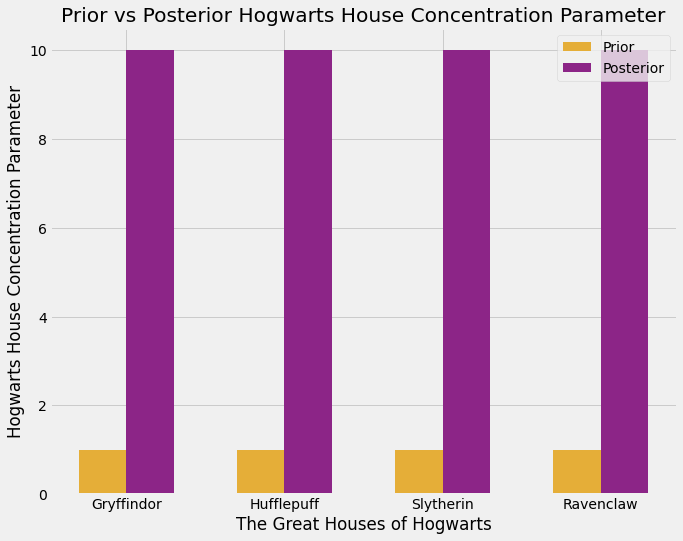

In [14]:
# Check predicted house concentration parameters
print(f"house concentrations: {house_concentrations}")
predicted_house_concentrations = house_concentrations.detach().numpy()
true_house_concentrations = torch.ones(4)

# Plot results
num_bins = 4
hogwarts_houses = ["Gryffindor", "Hufflepuff", "Slytherin", "Ravenclaw"]
house_index = [0, 1, 2, 3]
locs = [1, 2, 3, 4]
# Width of a bar
width = 0.3

fig, ax = plt.subplots(figsize=(10, 8))
for i, house_name in enumerate(hogwarts_houses):
    ax.bar(
        locs[i],
        true_house_concentrations[i],
        width,
        color=color_yellow,
        label='Prior')

    ax.bar(
        locs[i] + width,
        predicted_house_concentrations[i],
        width,
        color=color_purple,
        label='Posterior')

plt.xlabel("The Great Houses of Hogwarts")
plt.ylabel("Hogwarts House Concentration Parameter")
plt.title("Prior vs Posterior Hogwarts House Concentration Parameter")
plt.grid(True)
plt.legend(["Prior", "Posterior"], loc='upper right')
ax.set_xticks(np.array(locs) + width / 2)
ax.set_xticklabels(hogwarts_houses)
plt.show()

Plot prior vs posterior house probabilities.

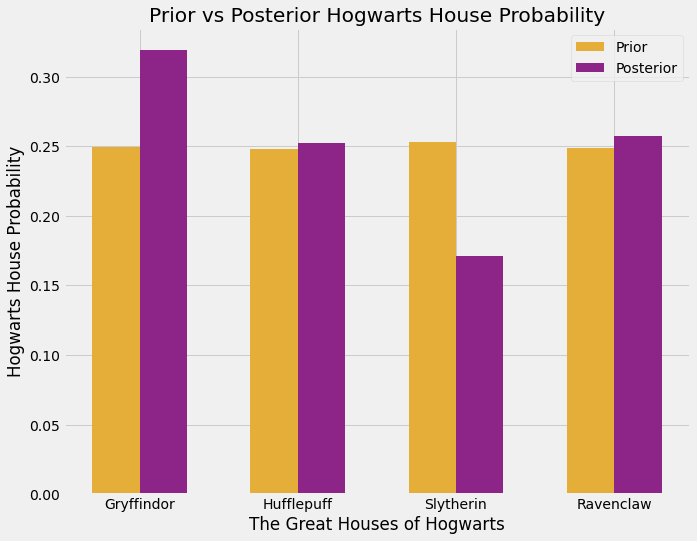

In [15]:
posterior_house_probabilities = (
    Dirichlet(house_concentrations).sample()).detach().numpy()

# Plot results
num_bins = 4
hogwarts_houses = ["Gryffindor", "Hufflepuff", "Slytherin", "Ravenclaw"]
house_index = [0, 1, 2, 3]
locs = [1, 2, 3, 4]
# Width of a bar
width = 0.3

fig, ax = plt.subplots(figsize=(10, 8))
for i, house_name in enumerate(hogwarts_houses):
    ax.bar(
        locs[i],
        mean_prior_house_probs[0][i],
        width,
        color=color_yellow,
        label='Prior')

    ax.bar(
        locs[i] + width,
        posterior_house_probabilities[i],
        width,
        color=color_purple,
        label='Posterior')

plt.xlabel("The Great Houses of Hogwarts")
plt.ylabel("Hogwarts House Probability")
plt.title("Prior vs Posterior Hogwarts House Probability")
plt.grid(True)
plt.legend(["Prior", "Posterior"], loc='upper right')
ax.set_xticks(np.array(locs) + width / 2)
ax.set_xticklabels(hogwarts_houses)
plt.show()

Plot prior vs posterior personality type probabilities.

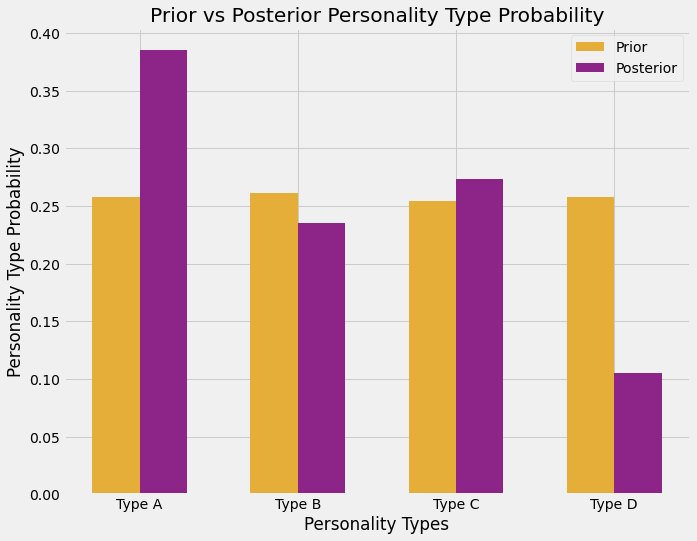

In [16]:
posterior_personality_probabilities = (
    Dirichlet(personality_concentrations).sample()).detach().numpy()

# Plot results
num_bins = 4
personality_types = ["Type A", "Type B", "Type C", "Type D"]
personality_index = [0, 1, 2, 3]
locs = [1, 2, 3, 4]
# Width of a bar
width = 0.3

fig, ax = plt.subplots(figsize=(10, 8))
for i, personality_type in enumerate(personality_types):
    ax.bar(
        locs[i],
        mean_prior_personality_probs[0][i],
        width,
        color=color_yellow,
        label='Prior')

    ax.bar(
        locs[i] + width,
        posterior_personality_probabilities[i],
        width,
        color=color_purple,
        label='Posterior')

plt.xlabel("Personality Types")
plt.ylabel("Personality Type Probability")
plt.title("Prior vs Posterior Personality Type Probability")
plt.grid(True)
plt.legend(["Prior", "Posterior"], loc='upper right')
ax.set_xticks(np.array(locs) + width / 2)
ax.set_xticklabels(personality_types)
plt.show()

Plot prior vs posterior herbology strength probabilities.

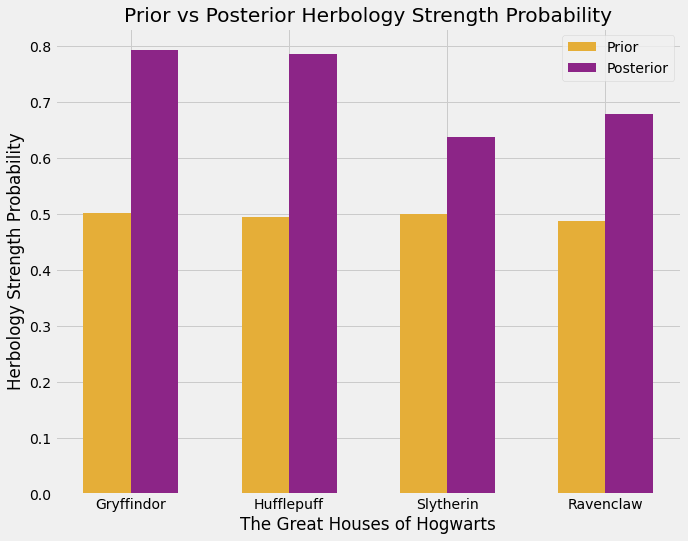

In [17]:
posterior_herbology_probabilities = (Beta(herbology_alphas, herbology_betas).sample())

# Plot results
num_bins = 4
hogwarts_houses = ["Gryffindor", "Hufflepuff", "Slytherin", "Ravenclaw"]
house_index = [0, 1, 2, 3]
locs = [1, 2, 3, 4]
# Width of a bar
width = 0.3

fig, ax = plt.subplots(figsize=(10, 8))
for i, house_name in enumerate(hogwarts_houses):
    ax.bar(
        locs[i],
        mean_prior_herbology_prob[0][i],
        width,
        color=color_yellow,
        label='Prior')

    ax.bar(
        locs[i] + width,
        posterior_herbology_probabilities[0][i],
        width,
        color=color_purple,
        label='Posterior')

plt.xlabel("The Great Houses of Hogwarts")
plt.ylabel("Herbology Strength Probability")
plt.title("Prior vs Posterior Herbology Strength Probability")
plt.grid(True)
plt.legend(["Prior", "Posterior"], loc='upper right')
ax.set_xticks(np.array(locs) + width / 2)
ax.set_xticklabels(hogwarts_houses)
plt.show()

Plot prior vs posterior quidditch mean parameters.

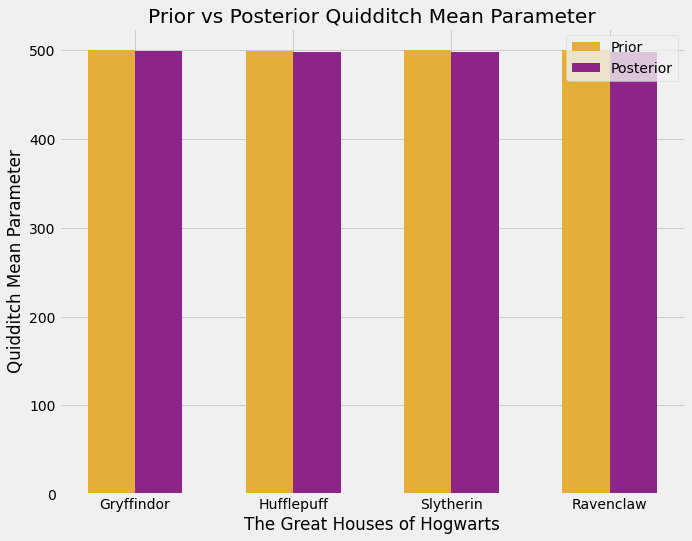

In [18]:
posterior_mus = quidditch_mean_locs.detach()
prior_mus = mean_prior_quidditch_rank_means[0].detach()

# Plot results
num_bins = 4
hogwarts_houses = ["Gryffindor", "Hufflepuff", "Slytherin", "Ravenclaw"]
house_index = [0, 1, 2, 3]
locs = [1, 2, 3, 4]
# Width of a bar
width = 0.3

fig, ax = plt.subplots(figsize=(10, 8))
for i, house_name in enumerate(hogwarts_houses):
    ax.bar(locs[i], prior_mus[i], width, color=color_yellow, label='Prior')

    ax.bar(
        locs[i] + width, posterior_mus[i], width, color=color_purple, label='Posterior')

plt.xlabel("The Great Houses of Hogwarts")
plt.ylabel("Quidditch Mean Parameter")
plt.title("Prior vs Posterior Quidditch Mean Parameter")
plt.grid(True)
plt.legend(["Prior", "Posterior"], loc='best')
ax.set_xticks(np.array(locs) + width / 2)
ax.set_xticklabels(hogwarts_houses)
plt.show()

Plot prior vs posterior quidditch standard deviation parameters. Note that the prior values are excessively large.

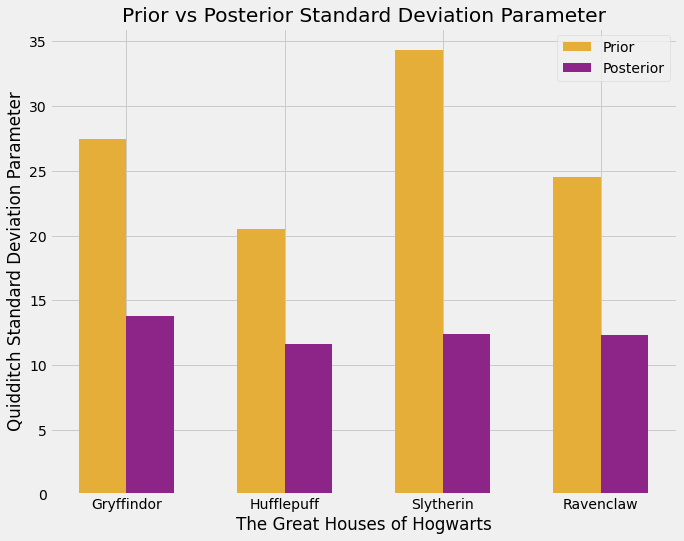

In [19]:
posterior_sigmas = quidditch_mean_scales.detach()
prior_sigmas = mean_prior_quidditch_rank_scales[0].detach()

# Plot results
num_bins = 4
hogwarts_houses = ["Gryffindor", "Hufflepuff", "Slytherin", "Ravenclaw"]
house_index = [0, 1, 2, 3]
locs = [1, 2, 3, 4]
# Width of a bar
width = 0.3

fig, ax = plt.subplots(figsize=(10, 8))
for i, house_name in enumerate(hogwarts_houses):
    ax.bar(locs[i], prior_sigmas[i], width, color=color_yellow, label='Prior')

    ax.bar(
        locs[i] + width, 
        posterior_sigmas[i], 
        width, 
        color=color_purple, 
        label='Posterior')

plt.xlabel("The Great Houses of Hogwarts")
plt.ylabel("Quidditch Standard Deviation Parameter")
plt.title("Prior vs Posterior Standard Deviation Parameter")
plt.grid(True)
plt.legend(["Prior", "Posterior"], loc='upper right')
ax.set_xticks(np.array(locs) + width / 2)
ax.set_xticklabels(hogwarts_houses)
plt.show()

Plot prior vs posterior quidditch score for Gryffindor. Note that the prior values are excessively large.

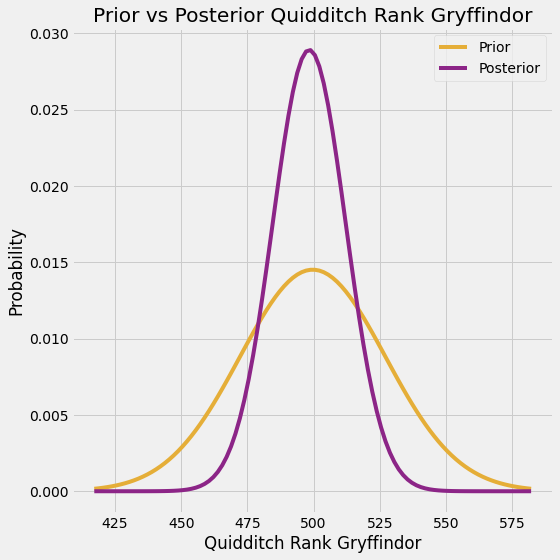

In [20]:
# Plot quidditch ranking distribution for Gryffindor
mu_prior = mean_prior_quidditch_rank_means[0].detach()[0]
sigma_prior = mean_prior_quidditch_rank_scales[0].detach()[0]

mu_posterior = quidditch_mean_locs[0].detach()
sigma_posterior = quidditch_mean_scales[0].detach()

# Fit both normal distribitions by taking min and max
low = np.min((mu_prior - 3*sigma_prior, mu_posterior - 3*sigma_posterior))
high = np.max((mu_prior + 3*sigma_prior, mu_posterior + 3*sigma_posterior))

# Make normal distributions
x = np.linspace(low,high, 100)
prior_score_gryffindor_dist = stats.norm.pdf(x, mu_prior, sigma_prior)
posterior_score_gryffindor_dist = stats.norm.pdf(
    x, 
    mu_posterior, 
    sigma_posterior)

# Make plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(x, prior_score_gryffindor_dist, color=color_yellow)
plt.plot(x, posterior_score_gryffindor_dist, color=color_purple)

plt.xlabel("Quidditch Rank Gryffindor")
plt.ylabel("Probability")
plt.title("Prior vs Posterior Quidditch Rank Gryffindor")
plt.grid(True)
plt.legend(["Prior", "Posterior"], loc='upper right')
plt.tight_layout()
plt.show()

Plot prior vs posterior quidditch score for Hufflepuff. Note that the prior values are excessively large.

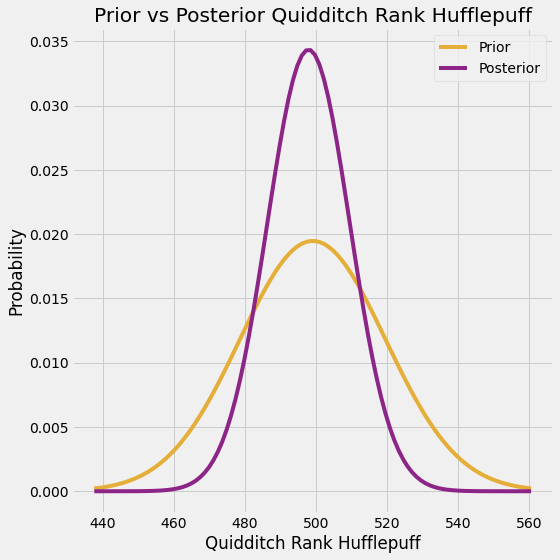

In [21]:
# Plot quidditch ranking distribution for Hufflepuff
mu_prior = mean_prior_quidditch_rank_means[0].detach()[1]
sigma_prior = mean_prior_quidditch_rank_scales[0].detach()[1]

mu_posterior = quidditch_mean_locs[1].detach()
sigma_posterior = quidditch_mean_scales[1].detach()

# Fit both normal distribitions by taking min and max
low = np.min((mu_prior - 3*sigma_prior, mu_posterior - 3*sigma_posterior))
high = np.max((mu_prior + 3*sigma_prior, mu_posterior + 3*sigma_posterior))

# Make normal distributions
x = np.linspace(low,high, 100)
prior_score_hufflepuff_dist = stats.norm.pdf(x, mu_prior, sigma_prior)
posterior_score_hufflepuff_dist = stats.norm.pdf(
    x, 
    mu_posterior, 
    sigma_posterior)

# Make plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(x, prior_score_hufflepuff_dist, color=color_yellow)
plt.plot(x, posterior_score_hufflepuff_dist, color=color_purple)

plt.xlabel("Quidditch Rank Hufflepuff")
plt.ylabel("Probability")
plt.title("Prior vs Posterior Quidditch Rank Hufflepuff")
plt.grid(True)
plt.legend(["Prior", "Posterior"], loc='upper right')
plt.tight_layout()
plt.show()

Plot prior vs posterior quidditch score for Slytherin. Note that the prior values are excessively large.

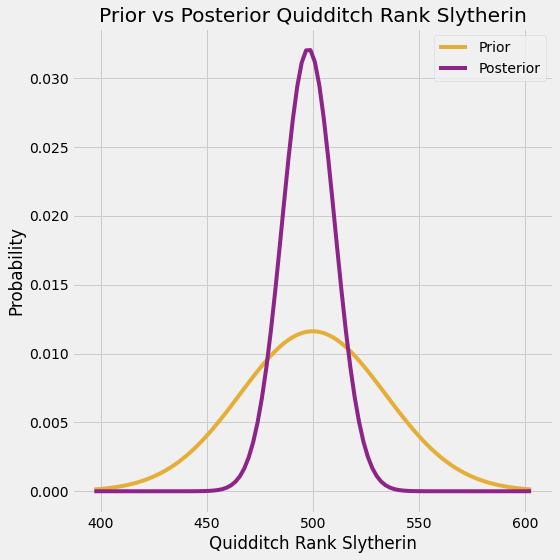

In [22]:
# Plot quidditch ranking distribution for Slytherin
mu_prior = mean_prior_quidditch_rank_means[0].detach()[2]
sigma_prior = mean_prior_quidditch_rank_scales[0].detach()[2]

mu_posterior = quidditch_mean_locs[2].detach()
sigma_posterior = quidditch_mean_scales[2].detach()

# Fit both normal distribitions by taking min and max
low = np.min((mu_prior - 3*sigma_prior, mu_posterior - 3*sigma_posterior))
high = np.max((mu_prior + 3*sigma_prior, mu_posterior + 3*sigma_posterior))

# Make normal distributions
x = np.linspace(low,high, 100)
prior_score_slytherin_dist = stats.norm.pdf(x, mu_prior, sigma_prior)
posterior_score_slytherin_dist = stats.norm.pdf(
    x, 
    mu_posterior, 
    sigma_posterior)

# Make plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(x, prior_score_slytherin_dist, color=color_yellow)
plt.plot(x, posterior_score_slytherin_dist, color=color_purple)

plt.xlabel("Quidditch Rank Slytherin")
plt.ylabel("Probability")
plt.title("Prior vs Posterior Quidditch Rank Slytherin")
plt.grid(True)
plt.legend(["Prior", "Posterior"], loc='upper right')
plt.tight_layout()
plt.show()

Plot prior vs posterior quidditch score for Ravenclaw. Note that the prior values are excessively large.

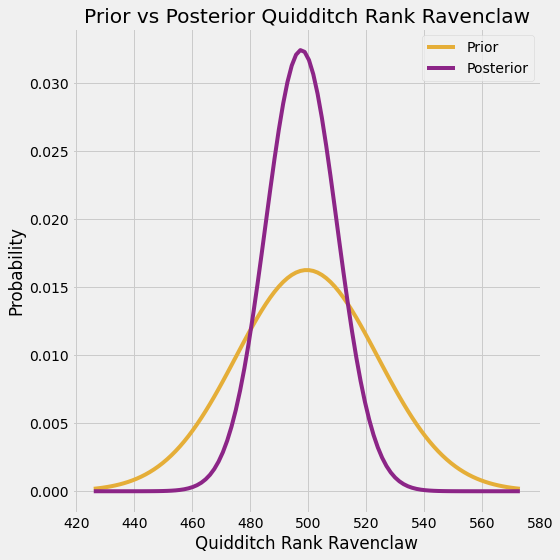

In [23]:
# Plot quidditch ranking distribution for Ravenclaw
mu_prior = mean_prior_quidditch_rank_means[0].detach()[3]
sigma_prior = mean_prior_quidditch_rank_scales[0].detach()[3]

mu_posterior = quidditch_mean_locs[3].detach()
sigma_posterior = quidditch_mean_scales[3].detach()

# Fit both normal distribitions by taking min and max
low = np.min((mu_prior - 3*sigma_prior, mu_posterior - 3*sigma_posterior))
high = np.max((mu_prior + 3*sigma_prior, mu_posterior + 3*sigma_posterior))

# Make normal distributions
x = np.linspace(low,high, 100)
prior_score_ravenclaw_dist = stats.norm.pdf(x, mu_prior, sigma_prior)
posterior_score_ravenclaw_dist = stats.norm.pdf(
    x, 
    mu_posterior, 
    sigma_posterior)

# Make plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(x, prior_score_ravenclaw_dist, color=color_yellow)
plt.plot(x, posterior_score_ravenclaw_dist, color=color_purple)

plt.xlabel("Quidditch Rank Ravenclaw")
plt.ylabel("Probability")
plt.title("Prior vs Posterior Quidditch Rank Ravenclaw")
plt.grid(True)
plt.legend(["Prior", "Posterior"], loc='upper right')
plt.tight_layout()
plt.show()